In [1]:
########################################
#LIBRARIES

import numpy as np
import torch
import torch.nn as nn
import pandas as pd
import time
import pydde as dde
import matplotlib.pyplot as plt
import json
import sklearn
import os

########################################
#PARAMETERS
nTimeSteps = 10; #at 60 Hz
epochs = 200
minibatch_size= 50
input_size = 9
hiddenlayers = [100]
use_case = 'qhold'
learning_rate = 0.01
LRdecay = 0.7
model_file_path = '../Trained_Models/'
sample_file_path = f'/Users/nicovonau/Code/thesis_pytorch/Data/Samples/data_{use_case}_{nTimeSteps}tsteps_1453/'
simulation_file_path = '/Users/nicovonau/Code/thesis_pytorch/Data/Simulations/pm_target.sim'
objective_file_path = f'/Users/nicovonau/Code/thesis_pytorch/Data/Objectives/pm_{use_case}.obj'
# set log level
dde.set_log_level(dde.LogLevel.off)
print(os.listdir(sample_file_path))

dyn = dde.DynamicSequence()
dyn.loadFile(simulation_file_path, nTimeSteps)
output_size = dyn.nParameters*nTimeSteps

['data_1.json', 'Sampling_qhold.py', 'qhold.out', '.DS_Store', 'data_0.json', 'data_10.json', 'data_7.json', 'data_test', 'data_6.json', 'data_11.json', 'Description.json', 'data_9.json', 'data_12.json', 'data_5.json', 'data_4.json', 'data_8.json', 'data_13.json', 'data_3.json', 'data_14.json', 'data_2.json']


In [2]:
#########################################
#LOAD TRAINING SAMPLES
number_of_files = len(os.listdir(sample_file_path))-5
samplenum = 1000*number_of_files
output_size = dyn.nParameters*nTimeSteps

p = np.zeros((dyn.nParameters*nTimeSteps, samplenum))
input = np.zeros((samplenum, input_size))

for filenum in range(number_of_files):
    with open(sample_file_path + f'data_{filenum}.json') as json_file:
        data = json.load(json_file)
        filesize = len(data['q'])
        for i, p_i in enumerate(data['p']):
            p[:, filenum*filesize+i] = np.array(p_i)
        for i, q_i in enumerate(data['q']):
            input[filenum*filesize+i, 0:3] = np.array(q_i)
        for i, qdot_i in enumerate(data['qdot']):
            input[filenum*filesize+i, 3:6] = np.array(qdot_i)
        for i, p_now_i in enumerate(data['p_now']):
            input[filenum*filesize+i, 6:9] = np.array(p_now_i)
p = p.transpose()

print(f'Shape of input: {input.shape}')
print(f'Shape of p: {p.shape}')
#Remove zeros
input = input[~(input == 0).all(1)]
p = p[~(p == 0).all(1)]
print(input.shape)
print(p.shape)

# Splitting the dataset into the Training set and Test set
#from sklearn.model_selection import train_test_split
#y_train, y_test, p_train, p_test = train_test_split(y_target, p, test_size = testsize)

#y_target = torch.tensor(y_train).float()
#p = torch.tensor(p_train).float()
input = torch.tensor(input).float()
p = torch.tensor(p).float()
#y_test = torch.tensor(y_test).float()
#p_test = torch.tensor(p_test).float()

#########################################
#LOAD TEST SAMPLES
number_of_files_test = len(os.listdir(sample_file_path + 'data_test/'))
samplenum_test = 1000*number_of_files_test

p_test = np.zeros((3*nTimeSteps, samplenum_test))
input_test = np.zeros((samplenum_test, input_size))

for filenum in range(number_of_files_test):
    with open(sample_file_path + f'data_test/data_{filenum}.json') as json_file:
        data = json.load(json_file)
        filesize = len(data['q'])
        for i, p_i in enumerate(data['p']):
            p_test[:, filenum*filesize+i] = np.array(p_i)
        for i, q_i in enumerate(data['q']):
            input_test[filenum*filesize+i, 0:3] = np.array(q_i)
        for i, qdot_i in enumerate(data['qdot']):
            input_test[filenum*filesize+i, 3:6] = np.array(qdot_i)
        for i, p_now_i in enumerate(data['p_now']):
            input_test[filenum*filesize+i, 6:9] = np.array(p_now_i)
p_test = p_test.transpose()

print(f'Shape of input_test: {input_test.shape}')
print(f'Shape of p_test: {p_test.shape}')
#Remove zeros
input_test = input_test[~(input_test == 0).all(1)]
p_test = p_test[~(p_test == 0).all(1)]
print(input_test.shape)
print(p_test.shape)

input_test = torch.tensor(input_test).float()
p_test = torch.tensor(p_test).float()

Shape of input: (15000, 9)
Shape of p: (15000, 30)
(15000, 9)
(15000, 30)
Shape of input_test: (5000, 9)
Shape of p_test: (5000, 30)
(5000, 9)
(5000, 30)


In [3]:
#Parameters
learning_rate = 0.001
epochs_s = [150]
minibatch_size = [10]
LRdecay_s = [0.7]
hiddenlayers_s = [[120]] 

In [4]:
start_time = time.time()
scores = []
index = 0
for e1 in epochs_s:
    for b1 in minibatch_size:
        for d in LRdecay_s:
            for h in hiddenlayers_s:
                class ActiveLearn(nn.Module):

                    def __init__(self, n_in, out_sz):
                        super(ActiveLearn, self).__init__()

                        self.L_in = nn.Linear(n_in, h[0])
                        self.H1 = nn.Linear(h[0], out_sz)
                        #self.H2 = nn.Linear(h[1], 3*nTimeSteps)
                        #self.H3 = nn.Linear(h[2], 3*nTimeSteps)
                        self.L_out = nn.Linear(out_sz, out_sz)
                        self.Relu = nn.ReLU(inplace=True)
                        #self.drop = nn.Dropout(p=0.3)
                        #self.norm1 = nn.BatchNorm2d(h[0])
                        #self.norm2 = nn.BatchNorm2d(h[1])
                    
                    def forward(self, input):
                        x = self.L_in(input)
                        #x = self.norm1(x)
                        #x = self.drop(x)
                        x = self.Relu(x)
                        x = self.H1(x)
                        #x = self.norm2(x)
                        x = self.Relu(x)
                        #x = self.H2(x)
                        #x = self.Relu(x)
                        #x = self.H3(x)
                        #x = self.Relu(x)
                        x = self.L_out(x)
                        return x


                model = ActiveLearn(input_size, output_size)

                criterion = nn.SmoothL1Loss()  # RMSE = np.sqrt(MSE)
                optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
                scheduler= torch.optim.lr_scheduler.StepLR(optimizer, step_size = 15, gamma=d, last_epoch=-1)
                #train
                torch.autograd.set_detect_anomaly(True)
                weight_c1 = 1 # p error condition
                batch = np.floor(samplenum/b1).astype(int)
                losses= []
                p_smoothness_errors = []
                basic_errors = [] #y_end_ and p_start error
                for e in range(e1):
                    for b in range(batch):
                        loss_batch = 0
                        smoothness_error_batch = 0
                        input_i = input[b*b1:b*b1+b1,:]
                        p_i = p[b*b1:b*b1+b1,:]
                        p_pred = model(input_i)
                        #error claculation
                        loss_batch = weight_c1* criterion(p_pred, p_i)
                        losses.append(loss_batch)
                        optimizer.zero_grad()
                        #Back Prop
                        loss_batch.backward()
                        optimizer.step()
                    scheduler.step()
                    LR= scheduler.get_lr()
                    if e%(epochs/10) == 0:
                        print(f'epoch: {e:3}/{epochs}    LR: {LR[0]:10.6f}  loss: {loss_batch.item():10.8f}')
                    
                print(f'epoch: {e:3} final loss: {loss_batch.item():10.8f}') # print the last line
                print(f'\nTraining completed. Total duration: {(time.time() - start_time)/60:.3f} min') # print the time elapsed


                #Test the data
                #model.eval()
                losses_test= []
                with torch.no_grad():
                    for i in range(samplenum_test):
                        p_val = model(input_test[i, :])
                        loss2 = criterion(p_val,p_test[i,:])
                        losses_test.append(loss2.clone().numpy())
                #plot test errors
                plot = plt.plot(losses, label = 'loss', linewidth=3)
                plt.legend()
                plt.yscale('log')
                plt.ylabel('error')
                plt.xlabel('batches')
                plt.savefig(f'../GridSearch_scores/{index}_Loss_.png')
                tot_error = sum(losses_test)
                mean_error = np.mean(losses_test)
                scores.append([index, tot_error, mean_error, e1, b1, d, h])
                index = index + 1
                print(f'TOTAL ERROR: {tot_error}    epochs: {e1}    batchsize: {b1}   LRdecay: {d}  hiddenlayer{h}')
print(f'\nDuration: {(time.time() - start_time)/60:.3f} min') # print the time elapsed

epoch:   0/200    LR:   0.001000  loss: 0.02039347
epoch:  20/200    LR:   0.000700  loss: 0.01096825
epoch:  40/200    LR:   0.000490  loss: 0.00897586
epoch:  60/200    LR:   0.000240  loss: 0.00779639


In [43]:
with open('Gridsearch_scores_qhold_passive.json', 'w') as outfile:
    json.dump(scores, outfile)

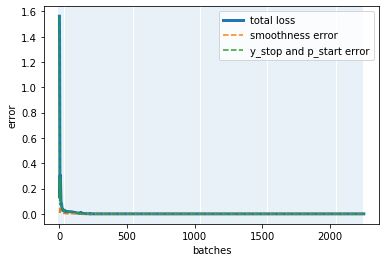

In [66]:
#plot errors after each epoch
epoch_lines = np.arange(0, epochs*batch, batch)
loss = plt.plot(losses, label = 'total loss', linewidth=3)
smoothness = plt.plot(p_smoothness_errors, label = 'smoothness error', linestyle='--')
basic = plt.plot(basic_errors, label = 'y_stop and p_start error', linestyle='--')
plt.legend()
plt.ylabel('error')
plt.xlabel('batches')
for xc in epoch_lines:
    plt.axvline(x=xc, linewidth = 0.2)
plt.show()